<a href="https://colab.research.google.com/github/ishandahal/stats453-deep_learning_torch/blob/main/Autoencoder/Convolutional_Autoencoder_NN__Interp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Convolutional Autoencoder with Nearest-neighbor Interpolation

#### Imports 

In [1]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [2]:
### Settings

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Hyperparameters
random_seed = 123
learning_rate = 0.005
num_epochs = 10
batch_size = 128



##########################
### MNIST DATASET
##########################


custom_transform = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=custom_transform,
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=custom_transform)


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Device: cuda:0


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)




Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


### Model

In [5]:
## Model

class ConvolutionalAutoencoder(torch.nn.Module):

    def __init__(self):
        super().__init__()

        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2

        # Encoder

        # 28x28x1 => 28x28x4
        self.conv_1 = torch.nn.Conv2d(in_channels=1,
                                     out_channels=4,
                                     kernel_size=3,
                                     stride=1,
                                     # (1(28-1) - 28 + 3) / 2 = 1
                                     padding=1)
        # 28x28x4 => 14x14x4
        self.pool_1 = torch.nn.MaxPool2d(kernel_size=2,
                                        stride=2,
                                        # (2(14 - 1) - 28 + 2) / 2 = 0
                                        padding=0)
        # 14x14x4 => 14x14x8
        self.conv_2 = torch.nn.Conv2d(in_channels=4,
                                      out_channels=8,
                                      kernel_size=3,
                                      stride=1,
                                      # (1(14 - 1) - 14 + 3) / 2 = 1
                                      padding=1)
        # 14x14x8 => 7x7x8
        self.pool_2 = torch.nn.MaxPool2d(kernel_size=2,
                                         stride=2,
                                         # (2(7 - 1) - 14 + 2) / 2 = 0
                                         padding=0)
        
        ## Decoder

        # 7x7x8 => 14x14x8
        # Unpool with interpolation 

        # 14x14x8 = 14x14x4
        self.conv_3 = torch.nn.Conv2d(in_channels=8,
                                      out_channels=4,
                                      kernel_size=3,
                                      stride=1,
                                      # (1(14 - 1) - 14 + 3) / 2 = 1
                                      padding=1)
        
        # 14x14x4 => 28x28x4
        # Unpool with interpolation 

        # 28x28x4 => 28x28x1
        self.conv_4 = torch.nn.Conv2d(in_channels=4,
                                      out_channels=1,
                                      kernel_size=3,
                                      stride=1,
                                      # (1(28 - 1) - 28 + 3) / 2) = 1
                                      padding=1)
    
    def forward(self, x):

        ## Encoder 
        x = self.conv_1(x)
        x = F.leaky_relu(x)
        x = self.pool_1(x)
        x = self.conv_2(x)
        x = F.leaky_relu(x)
        x = self.pool_2(x)

        ## Decoder 
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv_3(x)
        x = F.leaky_relu(x)
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv_4(x)
        return F.tanh(x)

torch.manual_seed(random_seed)
model = ConvolutionalAutoencoder()
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
start_time = time.time()

for epoch in range(num_epochs):
    for batch_idx, (features, labels) in enumerate(train_loader):

        features = features.to(device)

        # forward and back prop
        decoded = model(features)
        cost = F.mse_loss(decoded, features)
        optimizer.zero_grad()

        cost.backward()

        ## update model parameters
        optimizer.step()

        ### logging 
        # logging
        if not batch_idx % 50:
            print(f"Epoch: {epoch + 1:03d}/{num_epochs:03d} | Batch {batch_idx + 1:03d}/{len(train_loader):03d} | "
                  f"Cost: {cost:.4f}")
    
    print(f"Time elapsed: {(time.time() - start_time)/60:.2f} min")

print(f"Total time elapsed: {(time.time() - start_time)/60:.2f} min")

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch: 001/010 | Batch 001/469 | Cost: 0.9888
Epoch: 001/010 | Batch 051/469 | Cost: 0.1478
Epoch: 001/010 | Batch 101/469 | Cost: 0.1049
Epoch: 001/010 | Batch 151/469 | Cost: 0.0656
Epoch: 001/010 | Batch 201/469 | Cost: 0.0563
Epoch: 001/010 | Batch 251/469 | Cost: 0.0535
Epoch: 001/010 | Batch 301/469 | Cost: 0.0481
Epoch: 001/010 | Batch 351/469 | Cost: 0.0446
Epoch: 001/010 | Batch 401/469 | Cost: 0.0414
Epoch: 001/010 | Batch 451/469 | Cost: 0.0406
Time elapsed: 0.19 min
Epoch: 002/010 | Batch 001/469 | Cost: 0.0386
Epoch: 002/010 | Batch 051/469 | Cost: 0.0367
Epoch: 002/010 | Batch 101/469 | Cost: 0.0347
Epoch: 002/010 | Batch 151/469 | Cost: 0.0297
Epoch: 002/010 | Batch 201/469 | Cost: 0.0314
Epoch: 002/010 | Batch 251/469 | Cost: 0.0334
Epoch: 002/010 | Batch 301/469 | Cost: 0.0324
Epoch: 002/010 | Batch 351/469 | Cost: 0.0281
Epoch: 002/010 | Batch 401/469 | Cost: 0.0311
Epoch: 002/010 | Batch 451/469 | Cost: 0.0280
Time elapsed: 0.37 min
Epoch: 003/010 | Batch 001/469 | C

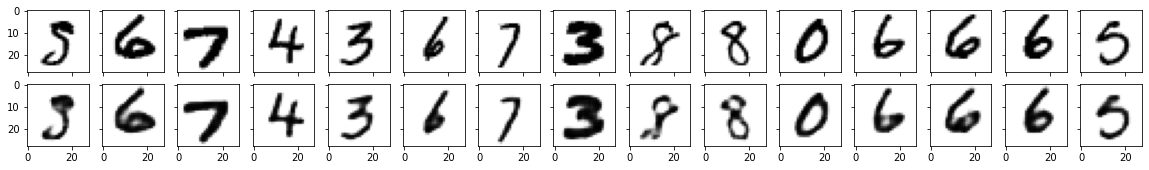

In [7]:
import matplotlib.pyplot as plt

##########################
### VISUALIZATION
##########################

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')